In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/Multi_Class_p1.zip"
# extract_path = "/content/Multi_Class_p1_extracted"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)


In [3]:
 # pip install tensorflow opencv-python

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
from glob import glob
import random
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import FileLink
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [5]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy("mixed_float16")

In [6]:
dataset_path = "/kaggle/input/multi-class-cancer-classification/Multi_Class_p1/Multi Cancer/Unified_Classes/"

# Check the class folders
classes = os.listdir(dataset_path)
print("Classes:", classes)

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}
print("Class Distribution:", class_counts)


Classes: ['lymph_fl', 'colon_bnt', 'brain_tumor', 'cervix_koc', 'colon_aca', 'lymph_cll', 'kidney_tumor', 'all_pro', 'cervix_dyk', 'oral_scc', 'all_benign', 'kidney_normal', 'all_early', 'lymph_mcl', 'lung_aca', 'lung_bnt', 'breast_benign', 'oral_normal', 'lung_scc', 'all_pre', 'brain_glioma', 'cervix_pab', 'cervix_sfi', 'breast_malignant', 'brain_notumor', 'brain_menin', 'cervix_mep']
Class Distribution: {'lymph_fl': 5000, 'colon_bnt': 5000, 'brain_tumor': 5000, 'cervix_koc': 5000, 'colon_aca': 5000, 'lymph_cll': 5000, 'kidney_tumor': 5000, 'all_pro': 5000, 'cervix_dyk': 5000, 'oral_scc': 5001, 'all_benign': 5000, 'kidney_normal': 5000, 'all_early': 5000, 'lymph_mcl': 5000, 'lung_aca': 5000, 'lung_bnt': 5000, 'breast_benign': 5000, 'oral_normal': 5001, 'lung_scc': 5000, 'all_pre': 5000, 'brain_glioma': 5000, 'cervix_pab': 5000, 'cervix_sfi': 5000, 'breast_malignant': 5000, 'brain_notumor': 2000, 'brain_menin': 5000, 'cervix_mep': 5000}


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


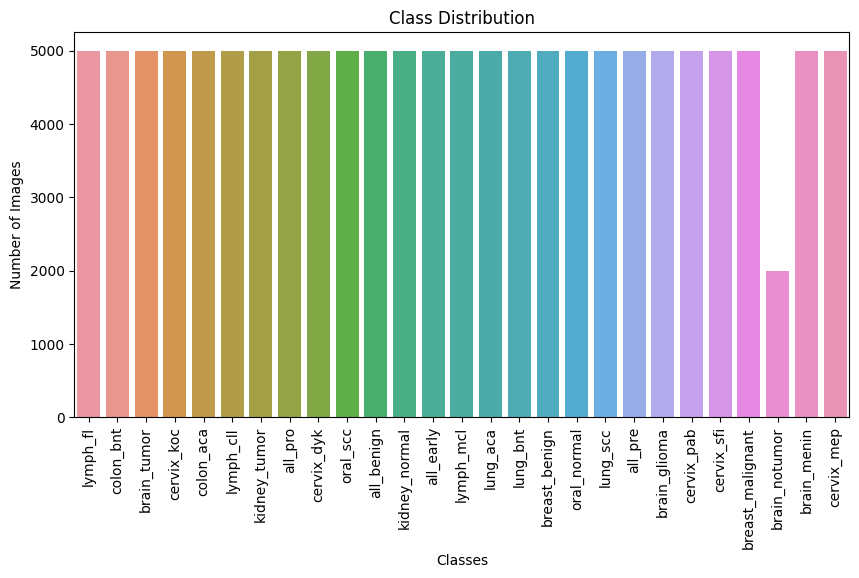

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

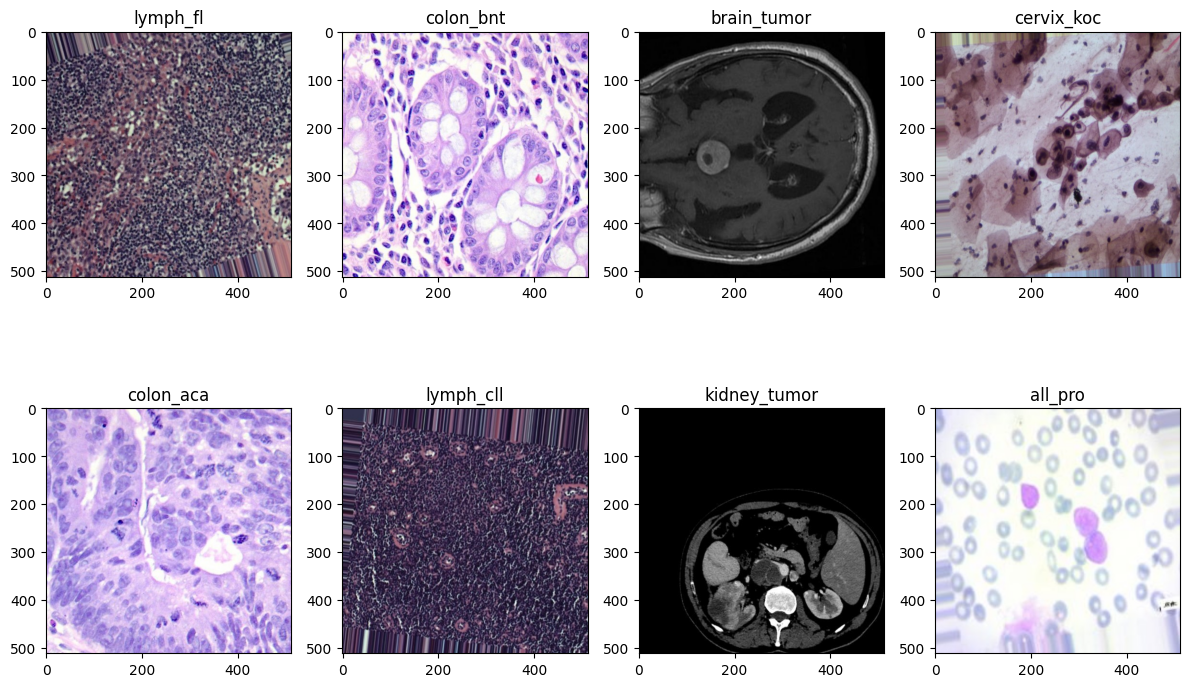

In [8]:
import cv2
import random

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:8]):
    img_path = os.path.join(dataset_path, cls, random.choice(os.listdir(os.path.join(dataset_path, cls))))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("on")

plt.tight_layout()
plt.show()


# DenseNet169

In [9]:
# Image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Generator (Only Rescaling, No Augmentation for Feature Extraction)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load images from dataset directory
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=False  # No shuffling for consistency in feature extraction
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Create a new data generator (Only Rescaling, No Augmentation)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Load test images from dataset directory
test_generator = test_datagen.flow_from_directory(
    dataset_path,  # <-- Update this with the actual path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset ="validation",
    shuffle=False  # No shuffling for consistent indexing
)

# Get class indices
class_indices = train_generator.class_indices
num_classes = len(class_indices)
print("Number of Classes:", num_classes)


Found 105602 images belonging to 27 classes.
Found 26400 images belonging to 27 classes.
Found 13200 images belonging to 27 classes.
Number of Classes: 27


In [10]:
# Load DenseNet169 without the top classification layers
base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze all layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Add Global Average Pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Create model to extract features
feature_extractor = Model(inputs=base_model.input, outputs=x)



51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
print(feature_extractor.summary()) 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ cast[0][0]             │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)        

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

None


In [12]:
import h5py
import gc

def extract_features_hdf5(generator, model, save_path):
    num_samples = generator.n
    batch_size = generator.batch_size
    feature_dim = model.output_shape[1]  # Feature size from the model

    # Create HDF5 file to store extracted features
    with h5py.File(f"{save_path}.h5", "w") as hdf5_file:
        # Create datasets in the file
        feature_dataset = hdf5_file.create_dataset("features", shape=(num_samples, feature_dim), dtype="float32")
        label_dataset = hdf5_file.create_dataset("labels", shape=(num_samples, generator.num_classes), dtype="float32")

        print(f"Extracting {num_samples} samples and saving to {save_path}.h5...")

        for i, (batch_x, batch_y) in enumerate(generator):
            start = i * batch_size
            end = start + batch_size

            # Extract features
            batch_features = model.predict(batch_x, verbose=0)

            # Save directly to HDF5
            feature_dataset[start:end] = batch_features
            label_dataset[start:end] = batch_y

            # Print progress every 100 batches
            if (i + 1) % 100 == 0 or i == len(generator) - 1:
                print(f"Processed {end}/{num_samples} samples...")

            # Free memory
            del batch_x, batch_y, batch_features
            gc.collect()

            if end >= num_samples:
                break  # Stop when all samples are processed

    print(f"Feature extraction completed. Features saved in {save_path}.h5")


# Extract and save features separately
def extract_and_save_all_features():
    extract_features_hdf5(train_generator, feature_extractor, "train_features")
    gc.collect()  # Force garbage collection after training data extraction

    extract_features_hdf5(val_generator, feature_extractor, "val_features")
    gc.collect()  # Force garbage collection after validation data extraction

    extract_features_hdf5(test_generator, feature_extractor, "test_features")
    gc.collect()  # Force garbage collection after test data extraction

# Run the extraction process
extract_and_save_all_features()


Extracting 105602 samples and saving to train_features.h5...
Processed 3200/105602 samples...
Processed 6400/105602 samples...
Processed 9600/105602 samples...
Processed 12800/105602 samples...
Processed 16000/105602 samples...
Processed 19200/105602 samples...
Processed 22400/105602 samples...
Processed 25600/105602 samples...
Processed 28800/105602 samples...
Processed 32000/105602 samples...
Processed 35200/105602 samples...
Processed 38400/105602 samples...
Processed 41600/105602 samples...
Processed 44800/105602 samples...
Processed 48000/105602 samples...
Processed 51200/105602 samples...
Processed 54400/105602 samples...
Processed 57600/105602 samples...
Processed 60800/105602 samples...
Processed 64000/105602 samples...
Processed 67200/105602 samples...
Processed 70400/105602 samples...
Processed 73600/105602 samples...
Processed 76800/105602 samples...
Processed 80000/105602 samples...
Processed 83200/105602 samples...
Processed 86400/105602 samples...
Processed 89600/105602 s

In [13]:
def load_hdf5_features(file_path):
    with h5py.File(file_path, "r") as hdf5_file:
        features = hdf5_file["features"][:]
        labels = hdf5_file["labels"][:]
    return features, labels

# Load extracted features and labels
X_train, y_train = load_hdf5_features("train_features.h5")
X_val, y_val = load_hdf5_features("val_features.h5")

# Print shapes
print("Train Features Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Validation Labels Shape:", y_val.shape)

Train Features Shape: (105602, 1664)
Train Labels Shape: (105602, 27)
Validation Features Shape: (26400, 1664)
Validation Labels Shape: (26400, 27)


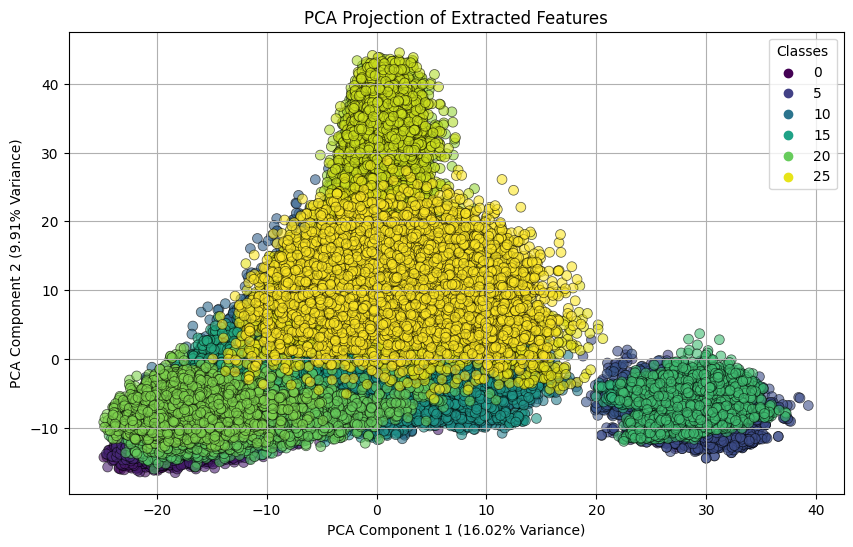

Explained Variance Ratio: [0.16022095 0.09908203]


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get class labels
y_labels = np.argmax(y_train, axis=1)

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette="viridis", alpha=0.6, edgecolor="k", s=50)

# Labels & Title
plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)")
plt.title("PCA Projection of Extracted Features")
plt.legend(title="Classes")
plt.grid(True)
plt.show()

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


# CNN 

In [15]:
cnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with num_classes
])

# Compile the Model
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Model Summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         852,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,020,187 (3.89 MB)

 Trainable params: 1,020,187 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('DenseNet169_cnn_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [18]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6850 - loss: 0.8820
Epoch 1: val_loss improved from inf to 0.24055, saving model to DenseNet169_cnn_model.keras
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6850 - loss: 0.8819 - val_accuracy: 0.9022 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 2/50
3281/3301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8757 - loss: 0.3171
Epoch 2: val_loss improved from 0.24055 to 0.17076, saving model to DenseNet169_cnn_model.keras
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8758 - loss: 0.3170 - val_accuracy: 0.9325 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 3/50
3283/3301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9025 - loss: 0.2546
Epoch 3: val_loss improved from 0.17076 to 0.16781, saving model to DenseNet169_cnn_model.keras
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9025 - loss: 0.2546 - val_accuracy: 0.9361 - val_loss: 0.1678 - learning_rate: 0.0010
Epoch 4/50
3287/3301 ━

In [19]:
# Save the trained model
cnn_model.save("DenseNet169_CNN_model_final.keras")

print("Model training complete and saved!")

Model training complete and saved!


## Testing 

In [20]:
import h5py
import numpy as np

# Load test features and labels from HDF5
with h5py.File("test_features.h5", "r") as hdf5_file:
    X_test = np.array(hdf5_file["features"])
    y_test = np.array(hdf5_file["labels"])

# Print shapes to verify
print("Test Features Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)


Test Features Shape: (13200, 1664)
Test Labels Shape: (13200, 27)


In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9922 - loss: 0.0227
Test Accuracy: 98.07%
Test Loss: 0.0523


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       0.99      0.98      0.99       500
           5       0.97      0.97      0.97       500
           6       1.00      1.00      1.00       200
           7       0.97      0.99      0.98       500
           8       0.97      0.98      0.98       500
           9       0.99      0.97      0.98       500
          10       1.00      1.00      1.00       500
          11       1.00      1.00      1.00       500
          12       1.00      1.00      1.00       500
          13       1.00      1.00      1.00       500
          14       1.00      1.00      1.00       500
          15       1.00      1.00      1.00       500
          16    

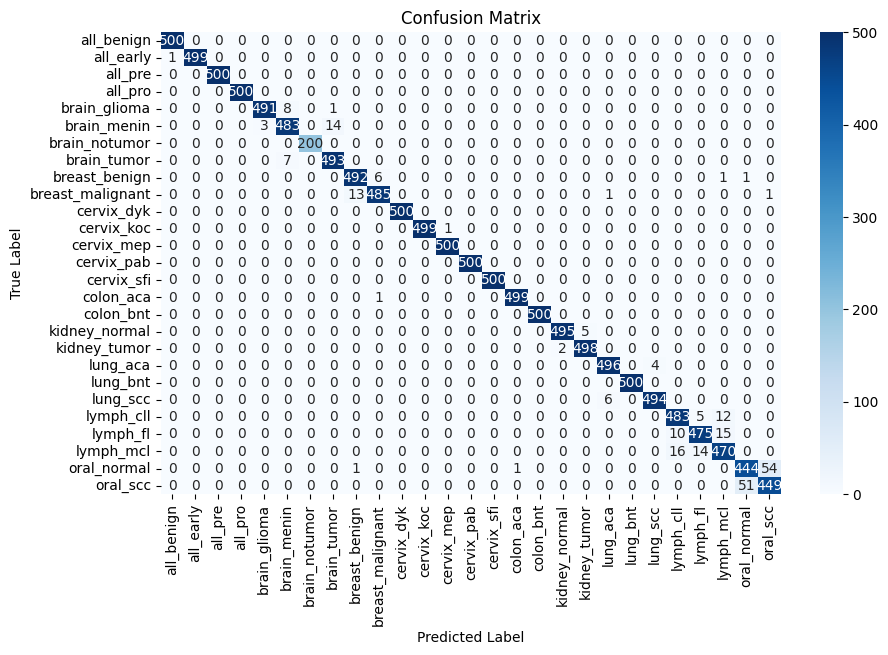

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict test set labels
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class index
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Generate classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


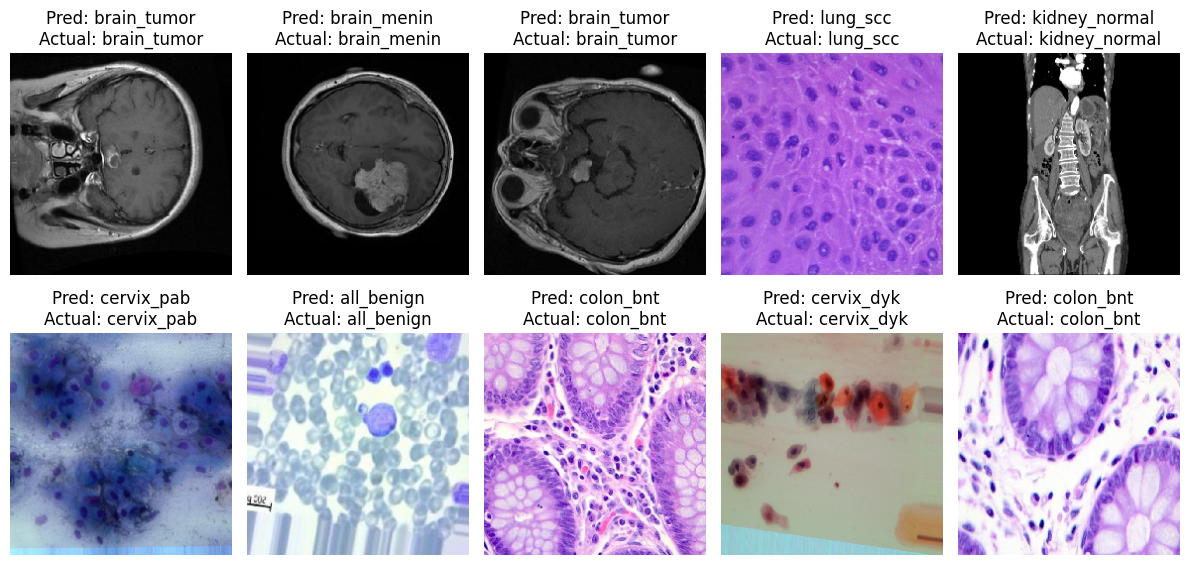

In [24]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Select random test samples
indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)

    # Load and preprocess the original image
    img_path = test_generator.filepaths[idx]  # Get original file path
    img = image.load_img(img_path, target_size=(224, 224))  # Load image
    img = np.array(img) / 255.0  # Normalize

    plt.imshow(img)
    plt.axis("off")
    
    # Prediction and actual label
    predicted_label = list(class_indices.keys())[y_pred_classes[idx]]
    actual_label = list(class_indices.keys())[y_true_classes[idx]]

    plt.title(f"Pred: {predicted_label}\nActual: {actual_label}")

plt.tight_layout()
plt.show()


In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    # Load image and resize it to match DenseNet169 input size
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array


In [26]:
def extract_features_single_image(img_path, feature_extractor):
    img_array = preprocess_image(img_path)
    features = feature_extractor.predict(img_array)  # Extract features
    return features


In [27]:
def predict_real_image(img_path, feature_extractor, cnn_model, class_indices):
    # Extract features from real image
    features = extract_features_single_image(img_path, feature_extractor)
    
    # Get predictions
    prediction = cnn_model.predict(features)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get class index
    
    # Map class index to actual class name
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping
    predicted_label = class_labels[predicted_class]

    print(f"Predicted Class: {predicted_label}")


In [28]:
img_path = "/kaggle/input/multi-class-cancer-classification/Multi_Class_p1/Multi Cancer/Unified_Classes/brain_notumor/Te-noTr_0002.jpg"  # Replace with actual image path
predict_real_image(img_path, feature_extractor, cnn_model, class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Predicted Class: brain_notumor


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image

def predict_real_image(img_path, feature_extractor, cnn_model, class_indices):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using DenseNet169
    features = feature_extractor.predict(img_array, verbose=0)

    # Predict with CNN model
    predictions = cnn_model.predict(features, verbose=0)
    predicted_class = np.argmax(predictions)
    predicted_label = list(class_indices.keys())[predicted_class]

    # Confidence scores for each class
    class_labels = list(class_indices.keys())
    confidences = predictions[0]  # Extract the 1D array from predictions

    # Plot Image & Prediction Confidence
    plt.figure(figsize=(10, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("on")
    plt.grid(True)
    plt.title(f"Prediction: {predicted_label}")

    # Display horizontal bar graph
    plt.subplot(1, 2, 2)
    sns.barplot(x=confidences, y=class_labels, palette="viridis")
    plt.xlabel("Confidence Score")
    plt.title("Prediction Confidence")

    plt.tight_layout()
    plt.show()

    return predicted_label, confidences



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


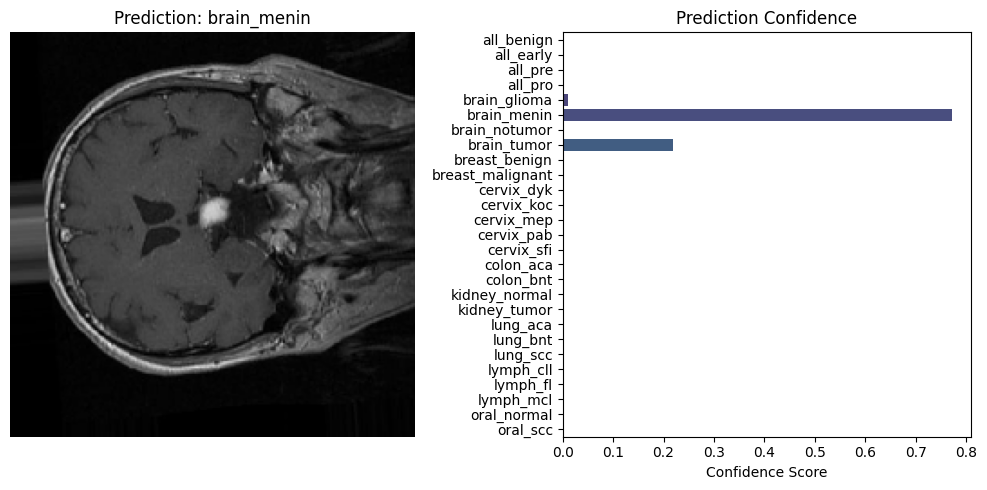

('brain_menin',
 array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.050e-02, 7.710e-01,
        2.944e-05, 2.184e-01, 0.000e+00, 0.000e+00, 2.980e-07, 2.122e-05,
        1.371e-06, 0.000e+00, 1.788e-07, 0.000e+00, 0.000e+00, 0.000e+00,
        1.788e-07, 0.000e+00, 0.000e+00, 0.000e+00, 6.557e-07, 1.192e-07,
        7.153e-07, 2.384e-07, 1.192e-07], dtype=float16))

In [36]:
# Example usage
img_path = "/kaggle/input/multi-class-cancer-classification/Multi_Class_p1/Multi Cancer/Unified_Classes/brain_menin/brain_menin_0003.jpg"  # Replace with actual image path
predict_real_image(img_path, feature_extractor, cnn_model, class_indices)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


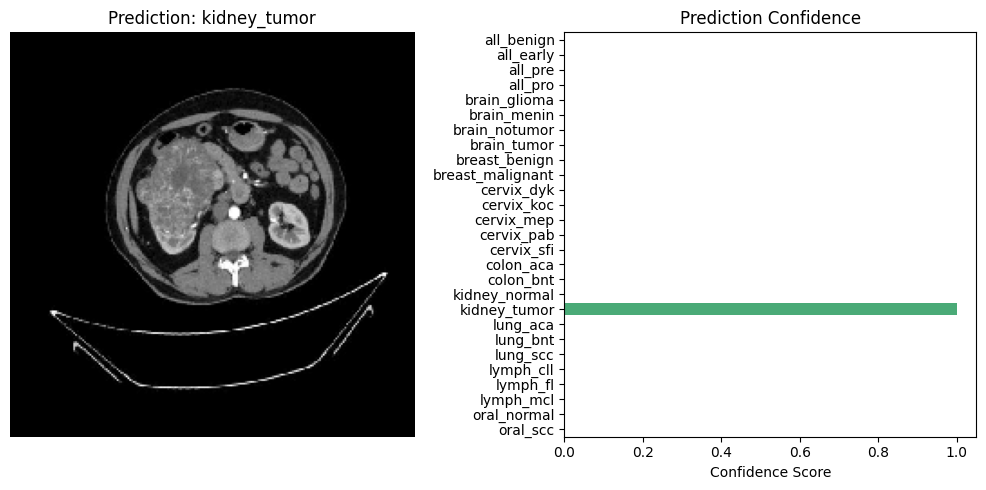

('kidney_tumor',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float16))

In [37]:
img_path = "/kaggle/input/multi-class-cancer-classification/Multi_Class_p1/Multi Cancer/Unified_Classes/kidney_tumor/kidney_tumor_0006.jpg"  
predict_real_image(img_path, feature_extractor, cnn_model, class_indices)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


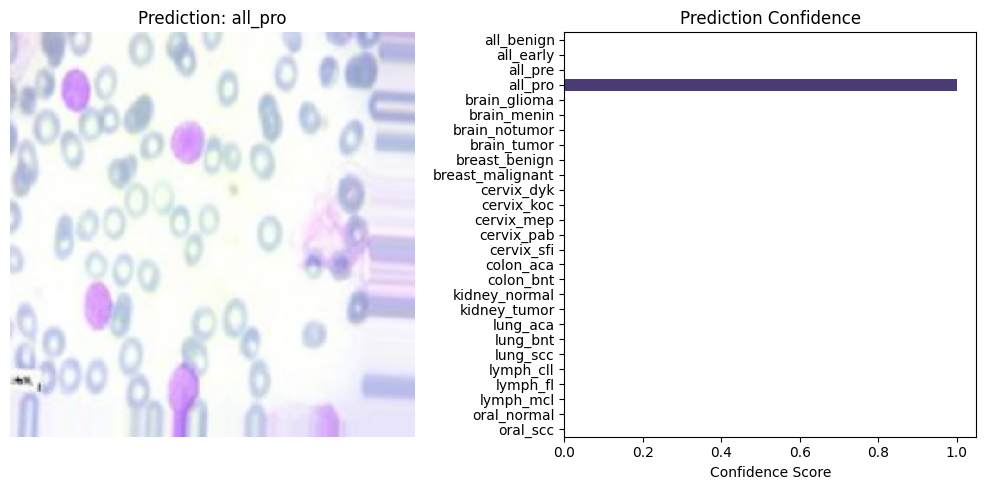

('all_pro',
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float16))

In [38]:
img_path = "/kaggle/input/multi-class-cancer-classification/Multi_Class_p1/Multi Cancer/Unified_Classes/all_pro/all_pro_0004.jpg"  
predict_real_image(img_path, feature_extractor, cnn_model, class_indices)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


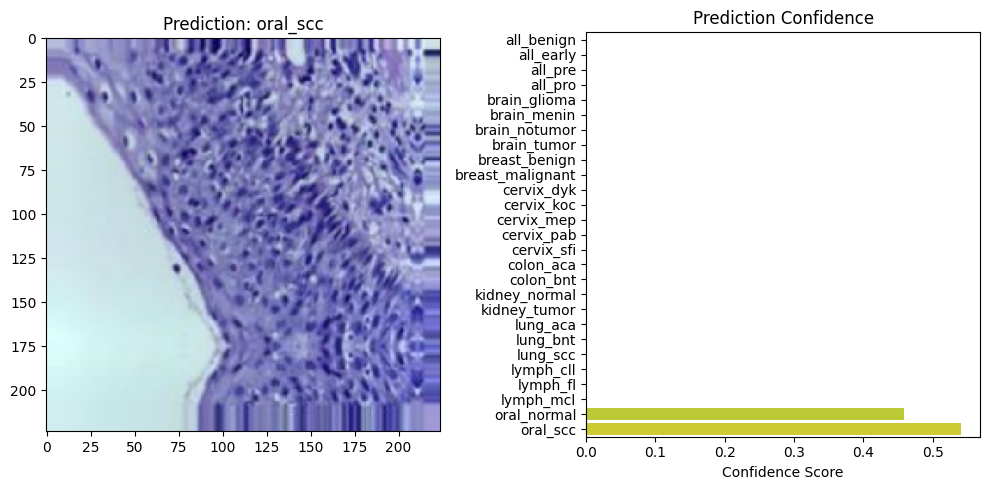

('oral_scc',
 array([5.96e-08, 0.00e+00, 5.96e-08, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 3.52e-06, 5.96e-08, 0.00e+00, 0.00e+00,
        0.00e+00, 2.38e-07, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 5.96e-08, 0.00e+00,
        0.00e+00, 4.59e-01, 5.41e-01], dtype=float16))

In [40]:
img_path = "/kaggle/input/multi-class-cancer-classification/Multi_Class_p1/Multi Cancer/Unified_Classes/oral_scc/oral_scc_0007.jpg"  
predict_real_image(img_path, feature_extractor, cnn_model, class_indices)